# 1 数据集信息
澳大利亚广播公司 ABC 发布的新闻头条数据

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [2]:
# 读取数据集
data = pd.read_csv("/data/course_data/abcnews-date-text/abcnews-date-text.csv",error_bad_lines=False,usecols =["headline_text"])
data.head()
data = data.head(10000)  # 获取部分数据快速运行，你可以尝试修改使用的数据量查看后续的建模效果，不过注意使用的数据越多后续模型训练的时间越长

In [3]:
# 打印数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   headline_text  10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


## 1.1 删除重复数据

In [4]:
# 查看重复的数据行，pandas.DataFrame.duplicated 使用方法详见：https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.duplicated.html
data[data['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(8)

,headline_text
9253,5 australian sars cases being monitored
9458,5 australian sars cases being monitored
6402,all walks of life follow protest path
6192,all walks of life follow protest path
6197,asio briefs crean on terrorist risk
6409,asio briefs crean on terrorist risk
6609,australia celebrates world cup victory
6813,australia celebrates world cup victory


In [5]:
# 删除重复行，pandas.DataFrame.drop_duplicates 使用方法详见：https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
data.drop_duplicates(inplace=True)

# 2 数据预处理 

## 2.1 为向量化表示进行前处理
进行自然语言处理时，必须将单词转换为机器学习算法可以利用的向量。如果目标是对文本数据进行机器学习建模，例如电影评论或推文或其他任何内容，则需要将文本数据转换为数字。此过程称为“嵌入”或“向量化”。  
进行向量化时，请务必记住，它不仅仅是将单个单词变成单个数字。单词可以转换为数字，整个文档就可以转换为向量。向量的维度往往不止一个，而且对于文本数据，向量通常是高维的。这是因为特征数据的每个维度将对应一个单词，而我们所处理的文档通常包含数千个单词。

## 2.2 TF-IDF
在信息检索中，tf–idf 或 TFIDF（term frequency–inverse document frequency）是一种数值统计，旨在反映单词对语料库中文档的重要性。在信息检索，文本挖掘和用户建模的搜索中，它通常用作加权因子。 tf-idf 值与单词在文档中出现的次数成正比，同时被单词在语料库中的出现频率所抵消，这有助于调整某些单词通常会更频繁出现的事实。 如今，tf-idf是最流行的术语加权方案之一。在数字图书馆领域，有83％的基于文本的推荐系统使用tf-idf。

搜索引擎经常使用tf–idf加权方案的变体作为在给定用户查询时对文档相关性进行评分和排名的主要工具。tf–idf可成功用于各种领域的停用词过滤，包括文本摘要和分类。

排名函数中最简单的是通过将每个查询词的tf–idf相加得出，许多更复杂的排名函数是此简单模型的变体。

In [7]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = data['headline_text'].values
# TfidfVectorizer 使用方法详见：http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(stop_words= stop_words)

X = vectorizer.fit_transform(desc)

In [8]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[5000:5100])

9820
['later', 'latest', 'latham', 'latif', 'latrobe', 'laughing', 'launceston', 'launch', 'launched', 'launches', 'laundering', 'laureates', 'laureus', 'lavender', 'laverton', 'law', 'lawful', 'lawnmowers', 'laws', 'lawyer', 'lawyers', 'lax', 'lay', 'lazaridis', 'lazio', 'lazios', 'lead', 'leader', 'leaderboard', 'leaders', 'leadership', 'leading', 'leads', 'league', 'leagues', 'leak', 'leaks', 'leaney', 'leap', 'learn', 'learner', 'learning', 'learns', 'lease', 'leases', 'leave', 'leaves', 'leaving', 'lebouc', 'lecturer', 'led', 'lee', 'leeds', 'lees', 'left', 'leg', 'legal', 'legality', 'legend', 'legionella', 'legislation', 'legislative', 'legitimacy', 'lehmann', 'leicester', 'leisel', 'leisure', 'lemon', 'lend', 'length', 'leniency', 'lennox', 'lens', 'lent', 'lenton', 'leonard', 'leone', 'leopards', 'lesbian', 'lessen', 'lester', 'let', 'lethal', 'letter', 'letters', 'letting', 'levee', 'level', 'levels', 'leven', 'leverkusen', 'levy', 'lewdness', 'lewis', 'lewiss', 'lga', 'liabi

## 2.3 Stemming
stemming 是将单词还原为词干（即词根形式）的过程。 词根形式不一定是单词本身，而是可以通过连接正确的后缀来生成单词。 例如，“fish”，“fishes”和“fishing”这几个词的词干都是“fish”，这是一个正确的单词。 另一方面，“study”，“studies”和“studying”一词源于“studi”，这不是一个正确的英语单词。

## 2.4 Tokenizing
Tokenization 将句子分解为单词和标点符号

In [10]:
stemmer = SnowballStemmer('english')  # SnowballStemmer 使用方法详见： https://www.kite.com/python/docs/nltk.SnowballStemmer
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')  #  RegexpTokenizer 使用方法详见： https://www.kite.com/python/docs/nltk.RegexpTokenizer

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

## 2.5  使用停用词、stemming 和自定义的 tokenizing 进行 TFIDF 向量化

In [11]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
print(len(word_features2))
print(word_features2[:50]) 

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


6909
['aa', 'aac', 'ab', 'aba', 'abalon', 'abandon', 'abar', 'abattoir', 'abbott', 'abc', 'abdic', 'abduct', 'abid', 'abigroup', 'abil', 'abl', 'ablaz', 'aboard', 'abolit', 'aborigin', 'abort', 'abov', 'abreast', 'abroad', 'absenc', 'absent', 'abu', 'abund', 'abus', 'abysm', 'ac', 'aca', 'academ', 'academi', 'acapulco', 'acb', 'accc', 'accent', 'accept', 'access', 'accid', 'accident', 'accommod', 'account', 'accredit', 'accus', 'ace', 'aceh', 'achiev', 'acid']


In [13]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()
print(len(words))
print(words[:50]) 

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1000
['abattoir', 'aborigin', 'abus', 'accc', 'accept', 'access', 'accid', 'accus', 'act', 'action', 'ad', 'address', 'adelaid', 'adf', 'admit', 'advanc', 'affect', 'afl', 'africa', 'age', 'agre', 'agreement', 'ahead', 'aid', 'aim', 'air', 'airlin', 'airport', 'ajax', 'al', 'alert', 'alic', 'aliv', 'alleg', 'allow', 'alp', 'ama', 'ambassador', 'ambul', 'american', 'amid', 'amp', 'announc', 'anoth', 'answer', 'anti', 'apologis', 'appeal', 'appoint', 'approv']


# 3 K-Means 聚类

## 3.1 使用手肘法选择聚类簇的数量
随着聚类数k的增大,样本划分会更加的精细,每个簇的聚合程度会逐渐提高,那么误差平方和SSE自然会逐渐变小,并且当k小于真实的簇类数时,由于k的增大会大幅增加每个簇的聚合程度,因此SSE的下降幅度会很大,而当k到达真实聚类数时,再增加k所得到的聚合程度回报会迅速变小,所以SSE的下降幅度会骤减,然后随着k值的继续增大而趋于平缓,也就是说SSE和k的关系类似于手肘的形状,而这个肘部对应的k值就是数据的真实聚类数.因此这种方法被称为手肘法.

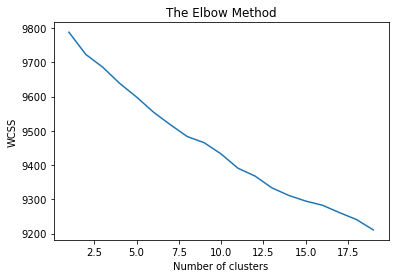

In [16]:
from sklearn.cluster import KMeans  # 使用方法详见： http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
wcss = []#WCSS - k-means 算法的评估标准，每个点到其簇的质心的距离之和
for i in range(1,20): 
#     kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,20),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

由于可能产生多个肘点，所以有时候不得不通过反复试验来选择合适数量的簇。下面展示不同数量簇的结果，以找出合适数量的簇。

In [17]:
print(words[250:300])

['death', 'debat', 'decid', 'decis', 'declar', 'defeat', 'defenc', 'defend', 'delay', 'demand', 'democrat', 'dengu', 'deni', 'dept', 'deputi', 'despit', 'destroy', 'detain', 'develop', 'die', 'differ', 'diplomat', 'disappoint', 'disast', 'discuss', 'dismiss', 'disput', 'divis', 'doctor', 'dog', 'dollar', 'domest', 'dont', 'dope', 'doubl', 'doubt', 'downer', 'draft', 'draw', 'drink', 'drive', 'driver', 'drop', 'drought', 'drug', 'dubai', 'dump', 'dure', 'e', 'earli']


## 3.2 Clusters 等于 3

In [28]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X3)
# We look at 3 the clusters generated by k-means.
# argsort 使用方法详见： https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]#对各聚类中心点的向量进行排序，返回特征值最大的26个特征的index
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))#通过返回的index，检索出对应的词

0 : iraq, war, protest, anti, say, howard, pm, ralli, missil, troop, deni, post, blair, bush, warn, downer, forc, fear, plan, destroy, british, condemn, turkey, student, tv
1 : plan, govt, new, win, council, iraqi, say, claim, warn, baghdad, report, fund, world, urg, water, kill, nsw, rain, cup, set, lead, death, open, hope, continu
2 : polic, man, charg, murder, probe, court, face, arrest, stab, death, search, jail, miss, car, fatal, drug, investig, assault, wa, crash, station, accid, cannabi, attack, hospit


## 3.3 Clusters 等于 5

In [40]:
# 重复上面的做法，仅改变聚类簇的数量 (尝试将上述过程封装成一个函数，减少代码的重读性，方便传参调用)
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X3)
# We look at 3 the clusters generated by k-means.
# argsort 使用方法详见： https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : polic, win, govt, council, iraqi, say, claim, warn, baghdad, report, fund, urg, kill, world, nsw, death, rain, water, cup, lead, crash, set, continu, troop, open
1 : iraq, war, anti, protest, say, howard, pm, missil, troop, ralli, deni, post, blair, bush, warn, forc, fear, downer, destroy, condemn, turkey, student, oil, bomb, british
2 : man, charg, face, murder, court, polic, stab, jail, death, assault, miss, car, accid, arrest, hospit, u, search, attack, fraud, child, guilti, sex, drug, fatal, offenc
3 : new, resolut, hope, appoint, ceo, presid, work, open, look, polic, hit, law, high, rate, compani, hospit, servic, iraq, coach, set, govt, tas, cabinet, treatment, announc
4 : plan, water, protest, shire, war, council, new, park, govt, union, manag, anti, firm, green, begin, group, m, welcom, merger, defend, health, rail, land, farmer, station


## 3.4 Clusters 等于 6

In [41]:
# 同上
kmeans = KMeans(n_clusters = 6, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X3)
# We look at 3 the clusters generated by k-means.
# argsort 使用方法详见： https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : plan, govt, new, win, council, iraqi, claim, warn, baghdad, report, world, fund, urg, water, kill, nsw, rain, cup, hope, death, set, concern, continu, crash, lead
1 : say, iraq, war, troop, iraqi, govt, crean, pm, baghdad, downer, need, bomb, korea, fund, group, minist, parti, raid, meet, bush, mp, attack, miss, soldier, warn
2 : man, charg, face, court, murder, jail, stab, assault, miss, u, accid, death, hospit, arrest, die, attack, plane, sex, car, injur, polic, convict, child, attempt, fatal
3 : open, lead, season, air, centr, new, super, win, nation, war, offic, davi, set, titl, art, leav, govt, miss, unit, final, medic, rout, inquiri, pm, adelaid
4 : iraq, war, protest, anti, howard, pm, ralli, missil, troop, deni, blair, post, fear, warn, bush, destroy, condemn, plan, student, forc, turkey, oil, market, tv, attack
5 : polic, probe, arrest, search, death, investig, man, drug, murder, cannabi, wa, fatal, car, protest, station, miss, victim, stab, charg, suspect, driver, nt, cor

## 3.5 Clusters 等于 8

In [42]:
# 同上
kmeans = KMeans(n_clusters = 8, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X3)
# We look at 3 the clusters generated by k-means.
# argsort 使用方法详见： https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : iraq, war, protest, anti, say, howard, pm, missil, ralli, troop, deni, blair, post, bush, forc, warn, fear, downer, destroy, british, condemn, turkey, student, tv, oil
1 : council, secur, elect, land, fund, plan, seek, welcom, consid, water, chang, urg, manag, decis, park, develop, studi, offer, hold, vote, centr, claim, poll, meet, debat
2 : polic, probe, man, arrest, search, death, investig, murder, charg, drug, stab, cannabi, wa, fatal, car, protest, miss, victim, station, road, suspect, nt, crash, bodi, shoot
3 : win, lead, season, fan, m, goal, india, award, open, hope, tiger, championship, gold, return, titl, thriller, coast, stage, streak, best, case, celebr, waratah, crush, end
4 : man, new, iraqi, charg, say, baghdad, kill, warn, claim, report, court, face, rain, death, crash, fund, set, nsw, water, continu, lead, hit, hospit, open, troop
5 : world, cup, urg, australia, championship, davi, semi, indoor, final, public, warn, farmer, race, miss, driver, push, ahead, set, cla

最后，我们可以根据不同簇数量产生的聚类结果，人工判断哪一个聚类的效果最好